In [3]:
!pip install wordcloud

In [4]:
pip install tld 

Note: you may need to restart the kernel to use updated packages.


In [5]:
!pip install torch

In [6]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [29]:
!pip install googlesearch-python

In [7]:
!pip install simpletransformers

In [8]:
import re
import os.path
import wordcloud
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [71]:
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud
from urllib.parse import urlparse
from tld import get_tld
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
from torch.nn import functional as F
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tld import get_tld, is_tld
from tabulate import tabulate

In [10]:
data = pd.read_csv("malicious_phish.csv")
print(data.shape)
data.head()

(651191, 2)


,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [12]:
data.isnull().sum()

url     0
type    0
dtype: int64

In [13]:
data.dtypes

url     object
type    object
dtype: object

In [14]:
count = data.type.value_counts()
count

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

Text(0, 0.5, 'Count')

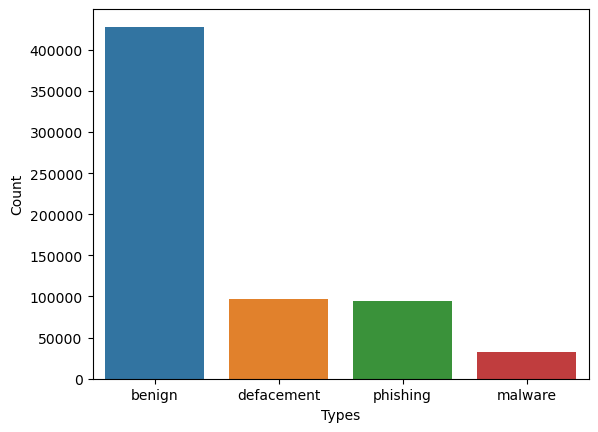

In [15]:
sns.barplot(x=count.index, y=count)
plt.xlabel('Types')
plt.ylabel('Count')

In [16]:
# get list of categorical columns
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
cat_cols

['url', 'type']

In [17]:
data['url'] = data['url'].replace('www.', '', regex=True) #omit the (www.) from the URL which is a sub domain in itself.
data

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://garage-pirenne.be/index.php?option=com_...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement
...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing


In [18]:
data['Category'] = data['type']
label_encoder = LabelEncoder()
data['Category'] = label_encoder.fit_transform(data['type'])
data.head()

,url,type,Category
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1


In [19]:
data.Category

0         3
1         0
2         0
3         1
4         1
         ..
651186    3
651187    3
651188    3
651189    3
651190    3
Name: Category, Length: 651191, dtype: int32

In [20]:
data

,url,type,Category
0,br-icloud.com.br,phishing,3
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,phishing,3
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing,3
651188,gamespot.com/xbox360/action/deadspace/,phishing,3
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing,3


## Plotting Wordcloud

In [21]:
data_benign = data[data.type=='benign']
data_defacement = data[data.type=='defacement']
data_malware = data[data.type=='malware']
data_phishing = data[data.type=='phishing']

In [22]:
data_benign

,url,type,Category
1,mp3raid.com/music/krizz_kaliko.html,benign,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0
5,http://buzzfil.net/m/show-art/ils-etaient-loin...,benign,0
6,espn.go.com/nba/player/_/id/3457/brandon-rush,benign,0
7,yourbittorrent.com/?q=anthony-hamilton-soulife,benign,0
...,...,...,...
603177,imetrica.net/css/,benign,0
603178,idxband.com/telin/images/e-online.php,benign,0
603179,coffeewithsophieinc.com/media/system/js/cadast...,benign,0
603180,conseguircreditos.webs.tl/,benign,0


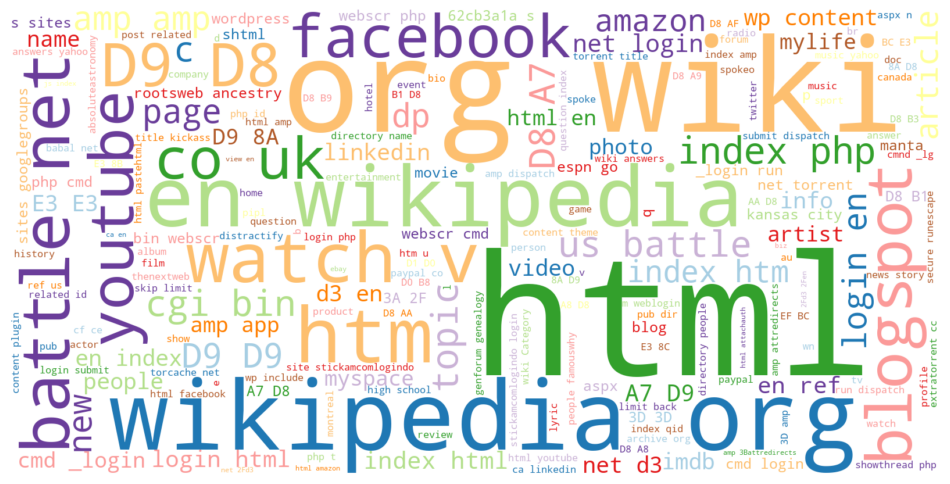

In [23]:
benign_url = " ".join(i for i in data_benign.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired', background_color='white').generate(benign_url)
plt.figure(figsize=(12,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

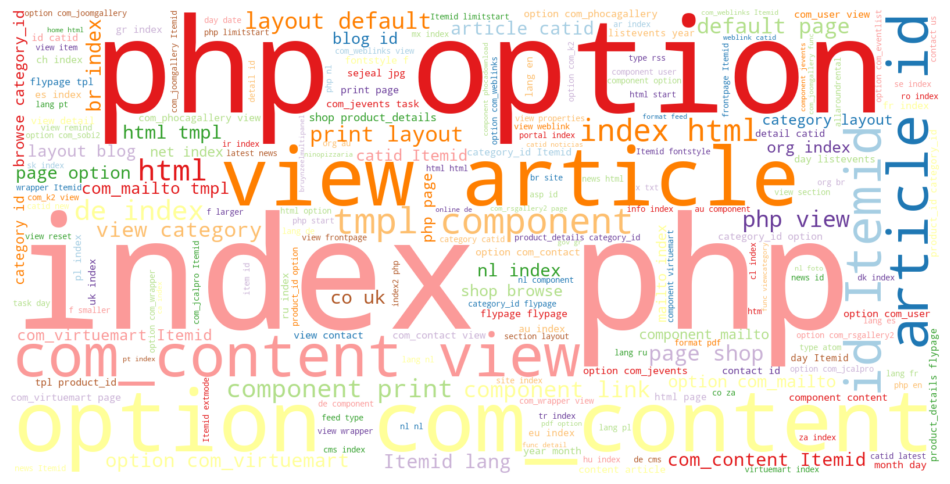

In [24]:
defacement_url = " ".join(i for i in data_defacement.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired', background_color='white').generate(defacement_url)
plt.figure(figsize=(12,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

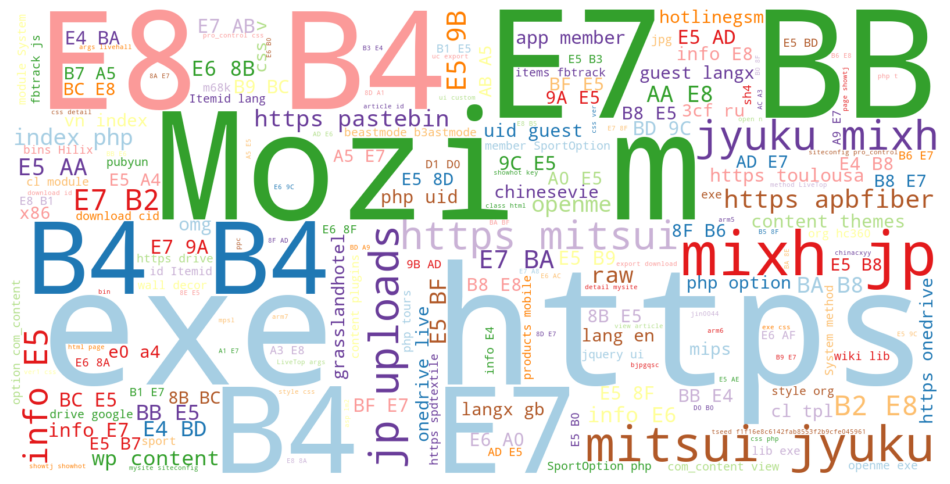

In [25]:
malware_url = " ".join(i for i in data_malware.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired', background_color='white').generate(malware_url)
plt.figure(figsize=(12,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

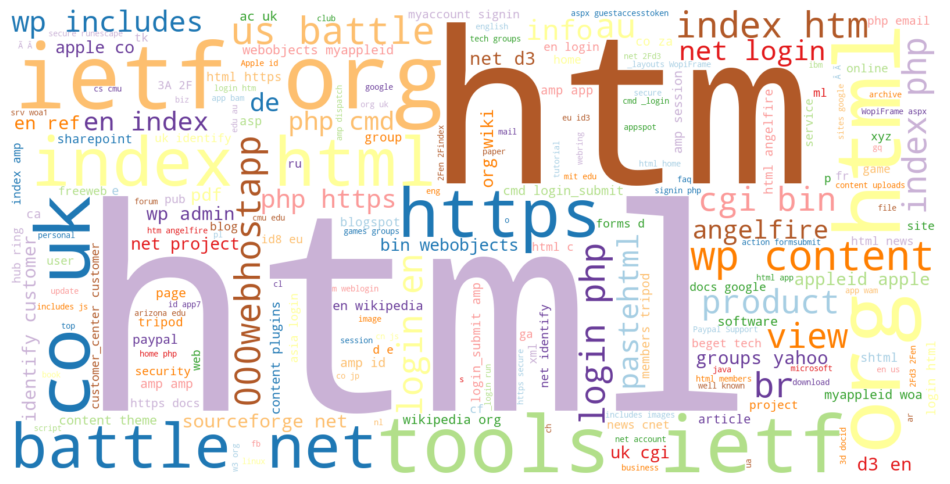

In [26]:
phish_url = " ".join(i for i in data_phishing.url)
wordcloud = WordCloud(width=1600, height=800, colormap='Paired', background_color='white').generate(phish_url)
plt.figure(figsize=(12,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Feature Engineering 

In [27]:
#Use of IP or not in domain
def have_ip_addr(url):
    match = re.search(
        '(([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\.'
        '([01]?\\d\\d?|2[0-4]\\d|25[0-5])\\/)|'  # IPv4
        '((0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\.(0x[0-9a-fA-F]{1,2})\\/)' # IPv4 in hexadecimal
        '(?:[a-fA-F0-9]{1,4}:){7}[a-fA-F0-9]{1,4}', url)  # Ipv6
    if match:
        return 1
    else:
        return 0
data['count_use_of_ip'] = data['url'].apply(lambda i: have_ip_addr(i))

In [28]:
def abnormal_url(url):
    hostname = urlparse(url).hostname
    hostname = str(hostname)
    match = re.search(hostname, url)
    if match:
        return 1
    else:
        return 0
data['count_abnormal_url'] = data['url'].apply(lambda i : abnormal_url(i))

In [30]:
data['count.'] = data['url'].apply(lambda i : i.count('.'))
data['count@'] = data['url'].apply(lambda i: i.count('@'))
data['count_https'] = data['url'].apply(lambda i : i.count('https'))
data['count_http'] = data['url'].apply(lambda i: i.count('http'))
data['count%'] = data['url'].apply(lambda i: i.count('%'))
data['count?'] = data['url'].apply(lambda i: i.count('?'))
data['count-'] = data['url'].apply(lambda i: i.count('-'))
data['count='] = data['url'].apply(lambda i: i.count('='))

In [31]:
def no_of_dir(url):
    urldir = urlparse(url).path
    return urldir.count('/')
data['count_dir'] = data['url'].apply(lambda i : no_of_dir(i))

def no_of_embed(url):
    urldir = urlparse(url).path
    return urldir.count('//')
data['count_embed'] = data['url'].apply(lambda i : no_of_embed(i))

In [32]:
def shortening_service(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0
data['short_url'] = data['url'].apply(lambda i : shortening_service(i))

In [33]:
data['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

In [34]:
sns.countplot

<function seaborn.categorical.countplot(*, x=None, y=None, hue=None, data=None, order=None, hue_order=None, orient=None, color=None, palette=None, saturation=0.75, dodge=True, ax=None, **kwargs)>

In [35]:
data['url_len'] = data['url'].apply(lambda i : len(str(i)))
data['hostname_len'] = data['url'].apply(lambda i : len(urlparse(i).netloc))

In [36]:
data.head()

,url,type,Category,count_use_of_ip,count_abnormal_url,count.,count@,count_https,count_http,count%,count?,count-,count=,count_dir,count_embed,short_url,url_len,hostname_len
0,br-icloud.com.br,phishing,3,0,0,2,0,0,0,0,0,1,0,0,0,0,16,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,0,2,0,0,0,0,0,0,0,2,0,0,35,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,0,2,0,0,0,0,0,0,0,3,0,0,31,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,0,1,2,0,0,1,0,1,1,4,1,0,0,84,17
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,0,1,2,0,0,1,0,1,1,3,1,0,0,235,23


In [37]:
def sus_words(url):
    match = re.search('PayPal|login|signin|bank|account|update|free|lucky|service|bonus|ebayisapi|webscr',
                      url)
    if match:
        return 1
    else:
        return 0
data['sus_url'] = data['url'].apply(lambda i : sus_words(i))

In [38]:
data.head()

,url,type,Category,count_use_of_ip,count_abnormal_url,count.,count@,count_https,count_http,count%,count?,count-,count=,count_dir,count_embed,short_url,url_len,hostname_len,sus_url
0,br-icloud.com.br,phishing,3,0,0,2,0,0,0,0,0,1,0,0,0,0,16,0,0
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,0,2,0,0,0,0,0,0,0,2,0,0,35,0,0
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,0,2,0,0,0,0,0,0,0,3,0,0,31,0,0
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,0,1,2,0,0,1,0,1,1,4,1,0,0,84,17,0
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,0,1,2,0,0,1,0,1,1,3,1,0,0,235,23,0


In [39]:
#Length of First Directory
def fd_length(url):
    urlpath= urlparse(url).path
    try:
        return len(urlpath.split('/')[1])
    except:
        return 0
data['fd_length'] = data['url'].apply(lambda i: fd_length(i))

In [40]:
#Length of Top Level Domain
data['tld'] = data['url'].apply(lambda i: get_tld(i,fail_silently=True))
def tld_length(tld):
    try:
        return len(tld)
    except:
        return -1
data['tld_length'] = data['tld'].apply(lambda i: tld_length(i))

In [41]:
data=data.drop("tld",1)

C:\Users\Prabhuta Chaudhary\AppData\Local\Temp\ipykernel_18364\1772274160.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data=data.drop("tld",1)


In [42]:
def digit_count(url):
    digits = 0
    for i in url:
        if i.isnumeric():
            digits = digits + 1
    return digits
data['count-digits']= data['url'].apply(lambda i: digit_count(i))

def letter_count(url):
    letters = 0
    for i in url:
        if i.isalpha():
            letters = letters + 1
    return letters
data['count-letters']= data['url'].apply(lambda i: letter_count(i))

In [43]:
data.head()

,url,type,Category,count_use_of_ip,count_abnormal_url,count.,count@,count_https,count_http,count%,...,count_dir,count_embed,short_url,url_len,hostname_len,sus_url,fd_length,tld_length,count-digits,count-letters
0,br-icloud.com.br,phishing,3,0,0,2,0,0,0,0,...,0,0,0,16,0,0,0,-1,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,0,2,0,0,0,0,...,2,0,0,35,0,0,5,-1,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,0,2,0,0,0,0,...,3,0,0,31,0,0,7,-1,1,25
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,0,1,2,0,0,1,0,...,1,0,0,84,17,0,9,2,7,60
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,0,1,2,0,0,1,0,...,1,0,0,235,23,0,9,3,22,199


## Split data into Training and Testing data

In [44]:
print (data.columns.tolist())

['url', 'type', 'Category', 'count_use_of_ip', 'count_abnormal_url', 'count.', 'count@', 'count_https', 'count_http', 'count%', 'count?', 'count-', 'count=', 'count_dir', 'count_embed', 'short_url', 'url_len', 'hostname_len', 'sus_url', 'fd_length', 'tld_length', 'count-digits', 'count-letters']


In [45]:
train,eva = train_test_split(data,test_size = 0.2)

In [46]:
data.head()

,url,type,Category,count_use_of_ip,count_abnormal_url,count.,count@,count_https,count_http,count%,...,count_dir,count_embed,short_url,url_len,hostname_len,sus_url,fd_length,tld_length,count-digits,count-letters
0,br-icloud.com.br,phishing,3,0,0,2,0,0,0,0,...,0,0,0,16,0,0,0,-1,0,13
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,0,2,0,0,0,0,...,2,0,0,35,0,0,5,-1,1,29
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,0,2,0,0,0,0,...,3,0,0,31,0,0,7,-1,1,25
3,http://garage-pirenne.be/index.php?option=com_...,defacement,1,0,1,2,0,0,1,0,...,1,0,0,84,17,0,9,2,7,60
4,http://adventure-nicaragua.net/index.php?optio...,defacement,1,0,1,2,0,0,1,0,...,1,0,0,235,23,0,9,3,22,199


# MODEL TRAINING

In [47]:
# Function to map sentiment labels to encoded values
def map_sentiment_label(label):
    return label_encoder.transform([label])[0]

# Apply the function to the 'sentiment' column in both train and eva DataFrames
train['label'] = train['type'].apply(map_sentiment_label)
eva['label'] = eva['type'].apply(map_sentiment_label)

print(train.shape)

(520952, 24)


In [48]:
train_df = pd.DataFrame({
    'text': train['url'][:1500].replace(r'\n', ' ', regex=True),
    'label': train['label'][:1500]
})

eval_df = pd.DataFrame({
    'text': eva['url'][-400:].replace(r'\n', ' ', regex=True),
    'label': eva['label'][-400:]
})

## BERT Model

In [49]:
model_bert = ClassificationModel('bert', 'bert-base-cased', num_labels=4, args={'reprocess_input_data': True, 'overwrite_output_dir': True},use_cuda=False)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [50]:
model_bert.train_model(train_df)

C:\Users\Prabhuta Chaudhary\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/188 [00:00<?, ?it/s]

(188, 0.6247759783600874)

In [51]:
result_bert, model_outputs_bert, wrong_predictions_bert = model_bert.eval_model(eval_df)

C:\Users\Prabhuta Chaudhary\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/400 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

In [52]:
result_bert

{'mcc': 0.6797004966444955, 'eval_loss': 0.4334762141108513}

In [53]:
model_outputs_bert

array([[ 3.91312075, -2.43512487, -1.90886021,  0.06566489],
       [-1.215608  ,  1.60300779,  1.02101421,  0.16820779],
       [ 3.07916498, -2.5996027 , -2.06134295,  0.86837173],
       ...,
       [ 4.00948238, -1.92761731, -1.85137546, -0.2271229 ],
       [ 2.7134459 , -2.4506309 , -1.7455169 ,  1.23383379],
       [ 3.7487793 , -2.64978147, -1.76322818,  0.41392049]])

In [66]:
true_labels_bert = eval_df['label']
predicted_labels_bert = [np.argmax(output) for output in model_outputs_bert]  # Get the predicted labels from the model outputs

accuracy_bert = accuracy_score(true_labels_bert, predicted_labels_bert)
precision_bert = precision_score(true_labels_bert, predicted_labels_bert, average='weighted')
recall_bert = recall_score(true_labels_bert, predicted_labels_bert, average='weighted')
f1_bert = f1_score(true_labels_bert, predicted_labels_bert, average='weighted')

print("Accuracy:", accuracy_bert*100)
print("Precision:", precision_bert*100)
print("Recall:", recall_bert*100)
print("F1 Score:", f1_bert*100)

Accuracy: 83.0
Precision: 83.39078014184398
Recall: 83.0
F1 Score: 80.33707922283304


In [74]:
confusion_bert = confusion_matrix(true_labels_bert, predicted_labels_bert)

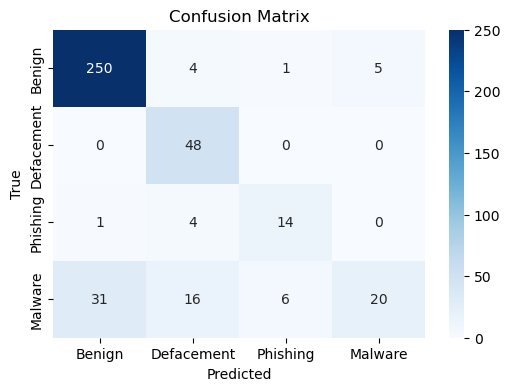

In [78]:
def plot_confusion_matrix(confusion_matrix, class_names):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',  
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['Benign', 'Defacement', 'Phishing', 'Malware'] 
plot_confusion_matrix(confusion_bert, class_names)

## RoBERTa Model

In [55]:
# Create a RoBERTa model
model_roberta = ClassificationModel('roberta', 'roberta-base', num_labels=4, args={'reprocess_input_data': True, 'overwrite_output_dir': True}, use_cuda=False)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
model_roberta.train_model(train_df)

C:\Users\Prabhuta Chaudhary\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/188 [00:00<?, ?it/s]

(188, 0.6612243632528376)

In [57]:
# Evaluate the model on the evaluation dataset
result_roberta, model_outputs_roberta, wrong_predictions_roberta = model_roberta.eval_model(eval_df)

C:\Users\Prabhuta Chaudhary\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/400 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

In [67]:
# Calculate accuracy, precision, and recall
true_labels_roberta = eval_df['label']
predicted_labels_roberta = [np.argmax(output) for output in model_outputs_roberta]

accuracy_roberta = accuracy_score(true_labels_roberta, predicted_labels_roberta)
precision_roberta = precision_score(true_labels_roberta, predicted_labels_roberta, average='weighted')
recall_roberta = recall_score(true_labels_roberta, predicted_labels_roberta, average='weighted')
f1_roberta = f1_score(true_labels_roberta, predicted_labels_roberta, average='weighted')

print("Accuracy:", accuracy_roberta*100)
print("Precision:", precision_roberta*100)
print("Recall:", recall_roberta*100)
print("F1 Score:", f1_roberta*100)

Accuracy: 79.0
Precision: 79.45718789407314
Recall: 79.0
F1 Score: 72.64781678498493


In [79]:
confusion_roberta = confusion_matrix(true_labels_roberta, predicted_labels_roberta)

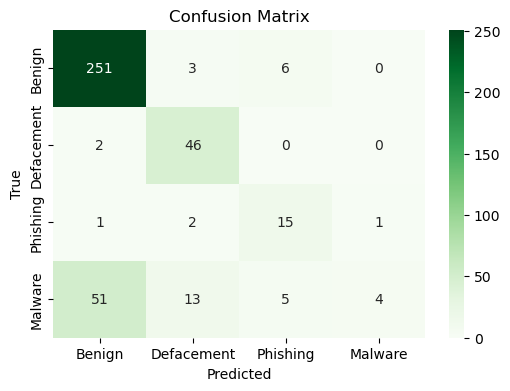

In [87]:
def plot_confusion_matrix(confusion_matrix, class_names):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt='d',
        cmap='Greens',  
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['Benign', 'Defacement', 'Phishing', 'Malware'] 
plot_confusion_matrix(confusion_roberta, class_names)

## XLNet Model

In [59]:
# Create an XLNet model
model_xlnet = ClassificationModel('xlnet', 'xlnet-base-cased', num_labels=4, args={'reprocess_input_data': True, 'overwrite_output_dir': True}, use_cuda=False)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
model_xlnet.train_model(train_df)

C:\Users\Prabhuta Chaudhary\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/188 [00:00<?, ?it/s]

(188, 0.7002959402991419)

In [61]:
# Evaluate the model on the evaluation dataset
result_xlnet, model_outputs_xlnet, wrong_predictions_xlnet = model_xlnet.eval_model(eval_df)

C:\Users\Prabhuta Chaudhary\anaconda3\lib\site-packages\simpletransformers\classification\classification_model.py:1454: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/400 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/50 [00:00<?, ?it/s]

In [68]:
# Calculate accuracy, precision, and recall
true_labels_xlnet = eval_df['label']
predicted_labels_xlnet = [np.argmax(output) for output in model_outputs_xlnet]

accuracy_xlnet = accuracy_score(true_labels_xlnet, predicted_labels_xlnet)
precision_xlnet = precision_score(true_labels_xlnet, predicted_labels_xlnet, average='weighted')
recall_xlnet = recall_score(true_labels_xlnet, predicted_labels_xlnet, average='weighted')
f1_xlnet = f1_score(true_labels_xlnet, predicted_labels_xlnet, average='weighted')

print("Accuracy:", accuracy_xlnet*100)
print("Precision:", precision_xlnet*100)
print("Recall:", recall_xlnet*100)
print("F1 Score:", f1_xlnet*100)

Accuracy: 82.25
Precision: 80.86422220663752
Recall: 82.25
F1 Score: 80.00781548281337


In [88]:
confusion_xlnet = confusion_matrix(true_labels_xlnet, predicted_labels_xlnet)

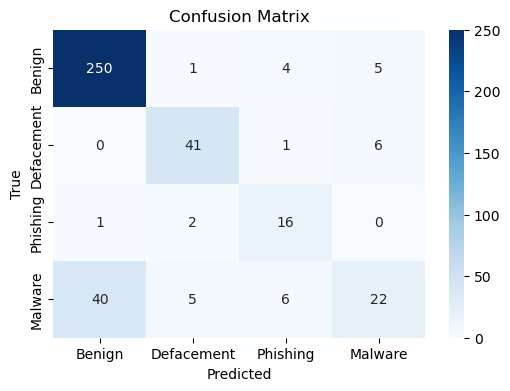

In [94]:
def plot_confusion_matrix(confusion_matrix, class_names):
    fig, ax = plt.subplots(figsize=(6, 4))
    sns.heatmap(
        confusion_matrix,
        annot=True,
        fmt='d',
        cmap='Blues',  
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

class_names = ['Benign', 'Defacement', 'Phishing', 'Malware'] 
plot_confusion_matrix(confusion_xlnet, class_names)

## Results

In [69]:
# Dummy data for three models
models = ["BERT", "RoBERTa", "XLNet"]
accuracy = [86.75, 85.75, 84.75]
precision = [86.78913003599703, 87.31790796963946, 83.38109650588319]
recall = [86.75, 85.75, 84.75]

# Create a list of lists for the table
data = [
    ["BERT", f"{accuracy[0]:.2f}%", f"{precision[0]:.2f}%", f"{recall[0]:.2f}%"],
    ["RoBERTa", f"{accuracy[1]:.2f}%", f"{precision[1]:.2f}%", f"{recall[1]:.2f}%"],
    ["XLNet", f"{accuracy[2]:.2f}%", f"{precision[2]:.2f}%", f"{recall[2]:.2f}%"],
]

# Create the table using tabulate
table = tabulate(data, headers=["Model", "Accuracy", "Precision", "Recall"], tablefmt="grid")

# Print or display the table
print(table)


+---------+------------+-------------+----------+
| Model   | Accuracy   | Precision   | Recall   |
+=========+============+=============+==========+
| BERT    | 86.75%     | 86.79%      | 86.75%   |
+---------+------------+-------------+----------+
| RoBERTa | 85.75%     | 87.32%      | 85.75%   |
+---------+------------+-------------+----------+
| XLNet   | 84.75%     | 83.38%      | 84.75%   |
+---------+------------+-------------+----------+


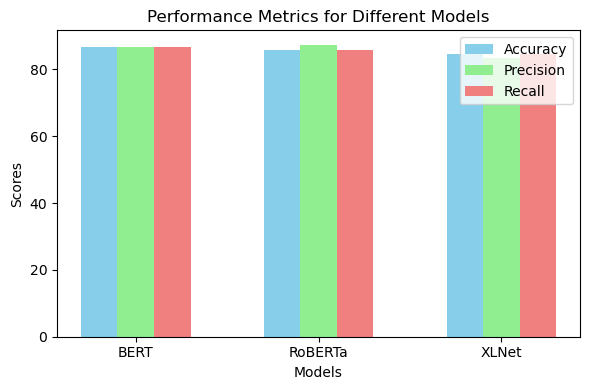

In [70]:
# Data for three models
models = ["BERT", "RoBERTa", "XLNet"]
accuracy = [86.75, 85.75, 84.75]
precision = [86.78913003599703, 87.31790796963946, 83.38109650588319]
recall = [86.75, 85.75, 84.75]

# Set the width of each bar
bar_width = 0.2
index = np.arange(len(models))

# Create subplots for accuracy, precision, and recall
plt.figure(figsize=(6, 4))

# Accuracy bars
plt.bar(index, accuracy, bar_width, label='Accuracy', color='skyblue')

# Precision bars
plt.bar(index + bar_width, precision, bar_width, label='Precision', color='lightgreen')

# Recall bars
plt.bar(index + 2 * bar_width, recall, bar_width, label='Recall', color='lightcoral')

# Labeling and ticks
plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Performance Metrics for Different Models')
plt.xticks(index + bar_width, models)
plt.legend()

# Show the graph
plt.tight_layout()
plt.show()
